# Build a Real-Time Stock Price Dashboard Web App
Estimated time needed: 60 minutes

# Objectives

After completing this lab, you will be able to:

- Use the Python libraries and tools for financial data analysis, including `yfinance` and `cufflinks`.
- Create interactive visualizations to gain insights into stock performance and portfolio management.
- Calculate and visualize cumulative returns for a weighted portfolio of multiple stocks in the semiconductor industry.
- Use open-source framework, `Mercury`, to share the exciting outcomes of your stock data analysis as an interactive web application with a global audience.



IBM has a special offer for watsonx.ai, a studio for new foundation models, generative AI and machine learning. To take advantage of this offer visit
<a href="https://dataplatform.cloud.ibm.com/registration/stepone?context=wx&apps=data_science_experience,watson_data_platform,cos
">watsonx.ai homepage</a>


Now, let's dive into the project step by step.


## Understanding Mercury
### 1. What is Mercury?
Mercury is an open-source(opens in a new tab) framework that helps you build web applications from your Jupyter Notebooks. It's built using technologies like Django, Django Channels, and React. Imagine it as a bridge between our notebooks and the web browser. When a user opens a notebook in a web browser, Mercury Server steps in and establishes a connection, much like a virtual highway, between the browser and itself. 

### 2. How It Works:

- **WebSocket Connection:** This connection is established between the user's web browser and Mercury Server. It's like a live channel of communication that lets data flow back and forth seamlessly.
- **Mercury Server and Worker:** Mercury Server ensures there's a "worker" ready to handle requests. Think of this worker as a skilled assistant. It connects to Mercury Server via WebSocket.
- **Action Forwarding:** When a user interacts with the app in their browser, every action they take is forwarded by Mercury Server to the worker. It's like passing notes between them.

- **Kernel Magic:** The worker maintains an open IPython kernel and understands the code from our notebook. It's our app's brain. When users interact with widgets, the worker's kernel executes the code related to those interactions.

- **Results Flow:** The worker sends the results of these executions back to the user's browser through Mercury Server. Imagine getting a quick answer after asking a question.

### 3. Why Mercury?
Mercury is the simplest way to transform our notebooks into web apps. It offers great features:
- You can show or hide your code easily.
- Your users can easily export executed notebook to PDF/HTML.
- You can produce files in the notebook and make them downloadable.
- You can share multiple notebooks with Mercury Cloud.


---


# Step 1: Setup


For this lab, we will be using the following libraries:

* `yfinance`: for fetching financial data from Yahoo Finance.
* `ipyvuetify`: for creating interactive web-based user interfaces with Vuetify components.
* `cufflinks`: for simplifying data visualization and charting when working with `Pandas` DataFrames in conjunction with `Plotly`.
* `mercury`: for converting the notebook into a web app.


### Installing Required Libraries


In [1]:
!pip install yfinance ipyvuetify cufflinks  mercury

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 72.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.7/81.7 kB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 30.5 MB/s eta 0:00:0000:01:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 928.0/928.0 kB 75.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

### Importing Required Libraries

_We recommend you import all required libraries in one place (here):_


In [2]:
import pandas as pd
import cufflinks as cf
cf.go_offline() # Configure Plotly to work in offline mode
import numpy as np
import yfinance as yf
from datetime import date
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import mercury as mr
from dateutil.relativedelta import relativedelta

---


# Step 2: Configure the Mercury App
In this step, we will instantiate a Mercury app by providing it a title and description. <font color="red">It's important to note that, although the output can't be displayed directly within the notebook, we use input widgets to define dynamic variables that will be used later in the app. These widgets allow users to interact with the app and customize their experience. 


In [3]:
app = mr.App(title="📈 Stock Price Dashboard", description="Dashboard with financial data", show_code=False)

mercury.App

Next, we create input widgets to capture user choices:

- ticker: This widget presents a selection of available stock tickers (e.g., NVDA, INTC, AMD, TSM, MU) for users to choose from. The selected ticker will be used for data analysis.
- period: Users can specify the number of past months (e.g., 3 months) of stock data they want to analyze. This numeric input allows a range from 1 to 12 months.

## Selecting Your Preferred Stock
Before advancing, take a moment to customize your stock selection based on your interests. While the tutorial initially showcases semiconductor stocks for demonstration purposes, you can simply replace 'NVDA', 'INTC', 'AMD', 'TSM', 'MU' with your preferred stock symbol to align with your specific area of interest and analysis goals.


In [4]:
ticker = mr.Select(label="Please select ticker", value='NVDA', 
                   choices=['NVDA', 'INTC', 'AMD', 'TSM', 'MU'])

mercury.Select

In [5]:
mr.Md(f"# Selected ticker: {ticker.value}")

# Selected ticker: NVDA

## Customizing the Time Period
You can also customize the time period for data analysis. The default period is set to 3 months, but you can modify it to suit your needs.


In [6]:
period = mr.Numeric(label="Past Month(s)", value=3, min=1, max=12)

mercury.Numeric

---


# Step 3: Visualize Stock Performance 
## Downloading and Visualizing Selected Stock Data
After configuring the app, we proceed to download the stock data for the selected ticker (e.g., NVDA) and the specified time period (e.g., 3 months). The downloaded data, in this case, represents NVIDIA Corporation (NVDA) stock data for analysis. We display the first few rows of this data to provide users with an initial glimpse of the dataset.

Please note that the actual interactivity and visualization of the data will be showcased within the Mercury app, but the initial data download and setup are illustrated here.


In [7]:
# Download NVIDIA Corporation (NVDA) stock data for analysis
stock_data = yf.download(ticker.value, start=date.today() - relativedelta(months=+period.value), end=date.today())
stock_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-07,423.220001,432.140015,421.799988,425.029999,424.994995,35525300
2023-07-10,426.570007,428.109985,416.489990,421.799988,421.765228,35390800
2023-07-11,424.809998,427.579987,420.670013,424.049988,424.015045,29824400
2023-07-12,430.329987,439.350006,427.769989,439.019989,438.983826,48127700
2023-07-13,445.179993,461.549988,444.920013,459.769989,459.732117,47820400
...,...,...,...,...,...,...
2023-10-02,440.299988,451.750000,438.609985,447.820007,447.820007,43329800
2023-10-03,448.079987,451.299988,432.459991,435.170013,435.170013,47085000
2023-10-04,437.420013,441.429993,432.920013,440.410004,440.410004,36182100


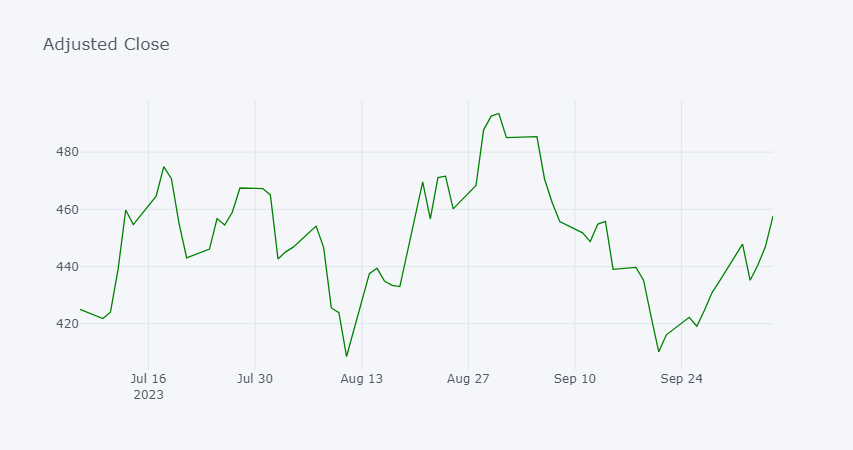

In [8]:
# Create and display an interactive line plot of NVDA's Adjusted Close Prices
stock_data['Adj Close'].iplot(title='Adjusted Close', colors=['green'])

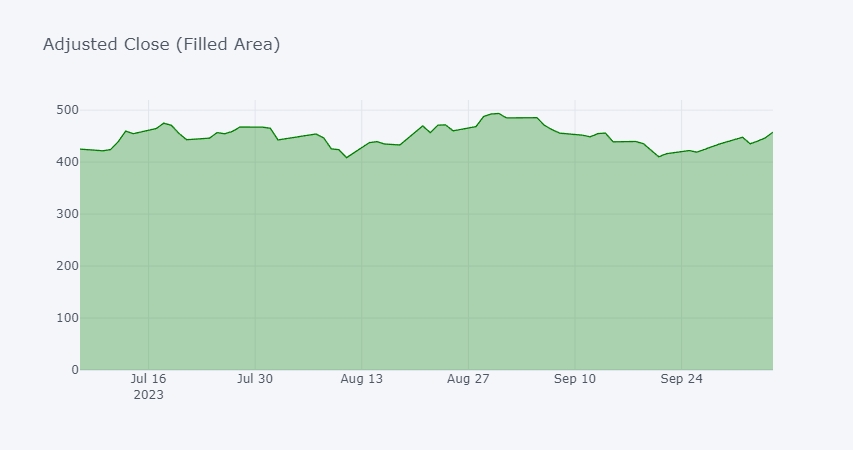

In [9]:
# Create and display an interactive filled area plot of NVDA's Adjusted Close Prices
stock_data['Adj Close'].iplot(title='Adjusted Close (Filled Area)', fill=True, colors=['green'])

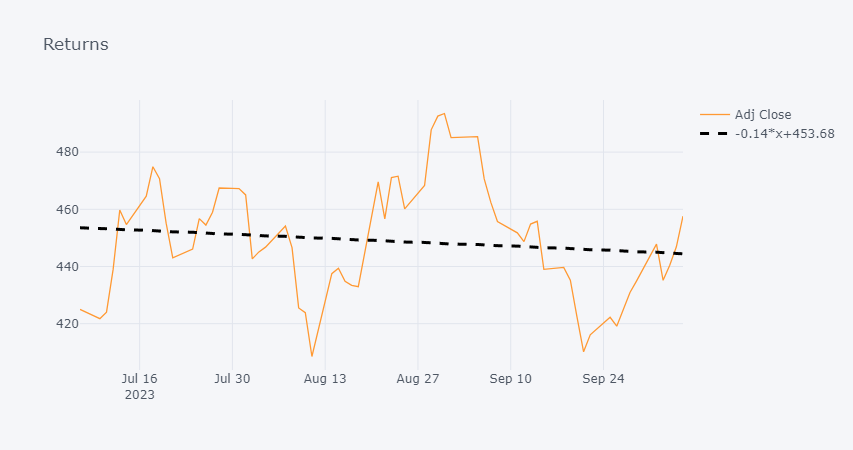

In [10]:
# Create and display an interactive line plot of NVDA's Returns with a best-fit line
stock_data['Adj Close'].iplot(title='Returns', bestfit=True, bestfit_colors=['black'])

## Quantitative Analysis with QuantFig
We'll perform quantitative analysis using the `QuantFig` class from `cufflinks`, adding technical indicators and volume data to gain deeper insights.


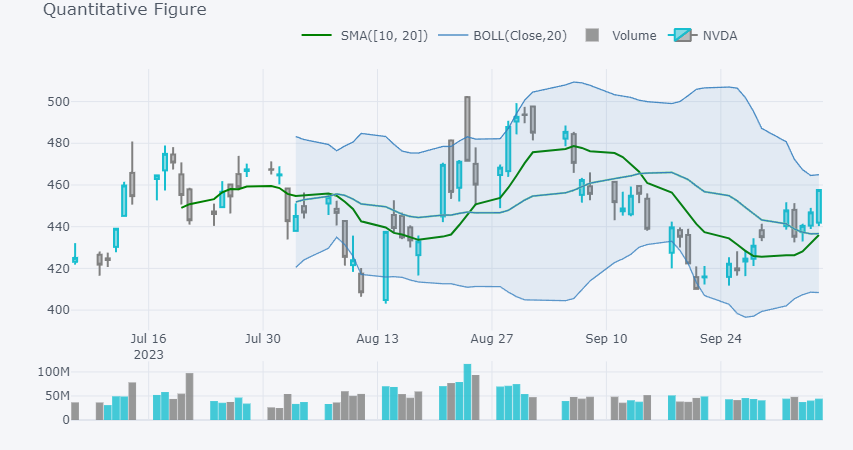

In [11]:
# Create a Quantitative Figure (QuantFig) for the NVDA stock data
qf = cf.QuantFig(stock_data, title='Quantitative Figure', legend='top', name=ticker.value)
qf.add_sma([10, 20], width=2, color=['green', 'lightgreen'], legendgroup=True)
qf.add_bollinger_bands()
qf.add_volume()
qf.iplot()

# Comparing Semiconductor Companies
Next, we will download and compare historical stock data for multiple semiconductor companies.


In [12]:
# Download stock data for semiconductor companies
semiconductor_tickers = ['NVDA', 'INTC', 'AMD', 'TSM', 'MU']
semiconductor_data = yf.download(semiconductor_tickers, start=date.today() - relativedelta(months=+period.value), end=date.today())
semiconductor_data

[*********************100%%**********************]  5 of 5 completed


Adj Close                                                \
                   AMD       INTC         MU        NVDA         TSM   
Date                                                                   
2023-07-07  113.169998  31.735826  60.548992  424.994995   99.712486   
2023-07-10  113.580002  32.622639  62.375942  421.765228   99.254852   
2023-07-11  111.320000  33.180626  63.494076  424.015045  100.737167   
2023-07-12  114.580002  33.858189  63.683762  438.983826  103.363533   
2023-07-13  115.919998  33.748585  64.422523  459.732117  105.024910   
...                ...        ...        ...         ...         ...   
2023-10-02  103.269997  35.459999  67.846817  447.820007   87.650002   
2023-10-03  100.080002  35.689999  67.717033  435.170013   85.410004   
2023-10-04  104.070000  35.930000  67.996567  440.410004   86.669998   
2023-10-05  102.910004  35.889999  68.935005  446.880005   87.029999   
2023-10-06  107.239998  36.189999  69.959999  457.619995   89.290001   

                 Close                                                ...  \
                   AMD       INTC         MU        NVDA         TSM  ...   
Date                                                                  ...   
2023-07-07  113.169998  31.850000  60.650002  425.029999  100.230003  ...   
2023-07-10  113.580002  32.740002  62.480000  421.799988   99.769997  ...   
2023-07-11  111.320000  33.299999  63.599998  424.049988  101.260002  ...   
2023-07-12  114.580002  33.980000  63.790001  439.019989  103.900002  ...   
2023-07-13  115.919998  33.869999  64.529999  459.769989  105.570000  ...   
...                ...        ...        ...         ...         ...  ...   
2023-10-02  103.269997  35.459999  67.959999  447.820007   87.650002  ...   
2023-10-03  100.080002  35.689999  67.830002  435.170013   85.410004  ...   
2023-10-04  104.070000  35.930000  68.110001  440.410004   86.669998  ...   
2023-10-05  102.910004  35.889999  69.050003  446.880005   87.029999  ...   
2023-10-06  107.239998  36.189999  69.959999  457.619995   89.290001  ...   

                  Open                                                \
                   AMD       INTC         MU        NVDA         TSM   
Date                                                                   
2023-07-07  114.160004  32.000000  61.430000  423.220001   99.080002   
2023-07-10  113.000000  31.870001  60.830002  426.570007  100.250000   
2023-07-11  111.660004  32.820000  62.599998  424.809998  102.330002   
2023-07-12  112.889999  33.689999  64.470001  430.329987  102.830002   
2023-07-13  115.760002  34.150002  64.180000  445.179993  105.000000   
...                ...        ...        ...         ...         ...   
2023-10-02  102.209999  35.610001  68.239998  440.299988   87.180000   
2023-10-03  101.800003  35.270000  67.169998  448.079987   87.000000   
2023-10-04  100.650002  36.520000  68.309998  437.420013   85.470001   
2023-10-05  103.410004  35.970001  68.610001  440.500000   86.830002   
2023-10-06  102.160004  35.869999  68.709999  441.929993   88.089996   

              Volume                                          
                 AMD      INTC        MU      NVDA       TSM  
Date                                                          
2023-07-07  37135100  28345700  15011100  35525300   8034000  
2023-07-10  49330200  36305700  16953100  35390800   8041600  
2023-07-11  59899500  28148800  13464500  29824400   7684600  
2023-07-12  57993100  37762200  13953600  48127700  10202000  
2023-07-13  49206700  32745800  11384700  47820400   9265900  
...              ...       ...       ...       ...       ...  
2023-10-02  45118600  26086200  14880500  43329800   6305000  
2023-10-03  48117000  45292600  12481500  47085000   8201700  
2023-10-04  51023200  39842200  12912800  36182100   7658500  
2023-10-05  51789700  25771200  14045000  39348300   6651700  
2023-10-06  64807500  33252300  15105100  43339700   9773800  

[65 rows x 30 columns]

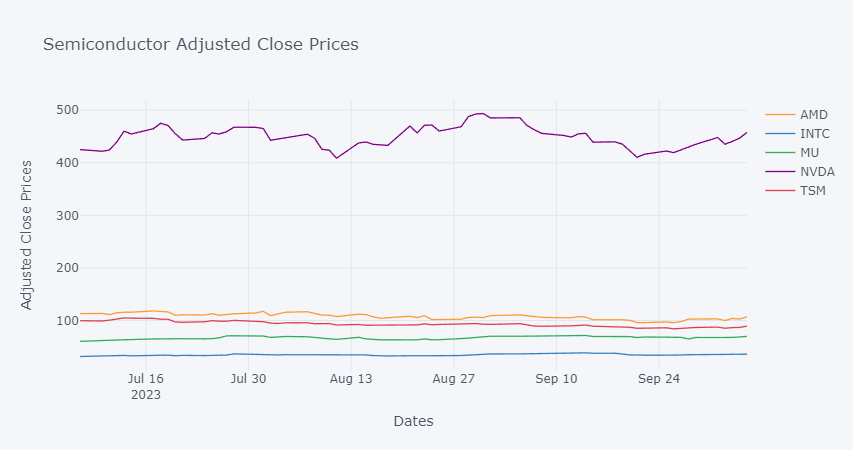

In [13]:
# Create and display an interactive line plot of Adjusted Close Prices for semiconductor companies
semiconductor_data['Adj Close'].iplot(title='Semiconductor Adjusted Close Prices', xTitle='Dates', yTitle='Adjusted Close Prices')

# Calculating Cumulative Returns
Finally, we'll calculate and visualize cumulative returns for a weighted portfolio of semiconductor stocks. You can define your own portfolio weights based on your investment strategy.


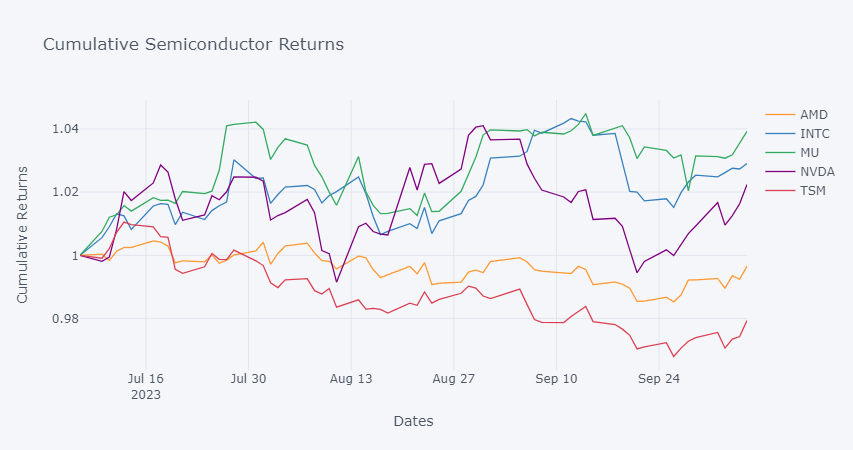

In [14]:
semiconductor_returns = semiconductor_data['Adj Close'].pct_change() # Calculate daily returns for each company
semiconductor_returns.iloc[0, :] = 0 # Set the initial value of returns to 0 (first day)
weights = np.array([0.1, 0.2, 0.25, 0.25, 0.2]) # Define the weights for each company in the portfolio; You can flexibly adjust these weights as needed
weighted_returns = weights * semiconductor_returns # Calculate the weighted returns for each company
cumulative_returns = (weighted_returns + 1).cumprod() # Calculate cumulative returns for the portfolio
cumulative_returns.iplot(title='Cumulative Semiconductor Returns', xTitle='Dates', yTitle='Cumulative Returns')

# Step 3: Deploy the Notebook as a Web App Using Mercury

The last crucial phase involves deploying our model as an interactive web application utilizing the open-source Mercury framework. With just a few clicks, you can harness its cloud capabilities to present your work to a wider audience! Later you will be asked to remove all images and cleared any Markdown cells and image tags. We've already taken care if you not sure just use the following file:



#### **Demo: [here](https://ibm-demo.runmercury.com/app/demo-6)**


## Step 3-1: Prepare the Notebook
1. Look for the **"Download Notebook"** button at the top of the notebook's toolbar to download the notebook.
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0OECEN/Screenshot%202023-09-07%20at%2010.53.04%20PM.png">
2. Once you've downloaded the notebook, you can remove the code or Markdown cells from the download file to not display those on the web. 

3. We can download  the   ```requirements.txt``` to our cloud environment, the file is used to specify the dependencies and their versions for a project. This file is commonly used with package management tools like pip to install the required packages for your project


In [15]:
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0OECEN/requirements.txt

--2023-10-07 13:44:40--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0OECEN/requirements.txt
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]      49  --.-KB/s    in 0s      

2023-10-07 13:44:40 (74.8 MB/s) - ‘requirements.txt’ saved [49/49]



4) Then download it to your local computer using the left tool bar

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0OECEN/Screenshot%202023-09-08%20at%205.47.24%20PM.png">




#### **You can refer to [the Notebook we demo on Mercury](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0OECEN/demo.ipynb)** 

## Step 3-2: Setup a Mercury Account
1. Sign up for a free account at [Mercury](https://cloud.runmercury.com/register).
2. After signing up, log in to your Mercury account.

## Step 3-3: Create Your First Site
1. Look for the green **"+ Add Site"** button and click it.
2. In the **"Title of your website"** field, enter `Stock Price Viz`.
3. In the "Subdomain at which website will be available" field, enter `demo`(Please note that site subdomain names must be unique. In case the chosen subdomain name is already taken, be prepared to modify it accordingly).
4. Click the green **"OK"** button at the bottom of the page.

## Step 3-4: Upload Your File
1. Click the **"Upload Files"** button on the right side of the site you just created.
2. Upload your downloaded `ipynb` notebook from Step 3-1 into your new site. 
3. Upload ```requirements.txt```
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0OECEN/Screenshot%202023-09-07%20at%2010.05.55%20PM.png">

## Step 3-5: Open the App
1. Return to the sites menu by clicking the **"[Sites](https://cloud.runmercury.com/sites)"** button on the top navigation bar.
2. Click the link associated with the `Stock Price Viz` site.
3. You need to wait for approximately 10 minutes to allow Mercury to display your Jupyter Notebook after opening the file.
4. Voilà! You've successfully accessed your site where you can explore and interact with your uploaded notebook.

<font color="red">**Note: For some reasons, we found that we need to make modifications to the Jupyter Notebook if the Notebook doesn't display smoothly on Mercury. This includes actions like deleting a code cell and then re-uploading it again to display the Jupyter Notebook.**


---


# Congratulations! You have completed the lab


## Authors


[Vicky Kuo](https://author.skills.network/instructors/vicky_kuo)


## Change Log


|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2023-09-01|0.1|Vicky Kuo|Initial Lab Created|


Copyright © 2023 IBM Corporation. All rights reserved.
